# Quantitative dissection of the simple repression input/output function 

(c) 2016 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
# Standard modules.
from __future__ import (print_function, division, 
                        absolute_import, unicode_literals)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Modules for image processing.
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.filters
import scipy.ndimage

# Instantiate the plotting environment.
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 20,
      'axes.facecolor': '#E3DCD0',
      'xtick.major' : 20,
      'xtick.labelsize': 'large',
      'ytick.labelsize': 30,
      'font.family': 'Lucida Sans Unicode',
      'grid.linestyle': ':',
      'grid.linewidth': 1.5,
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True,
      'legend.fontsize': 13}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette('deep', n_colors=10)
%matplotlib notebook

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In this exercise, we will test a statistical mechanical theory of genetic regulation through quantiative image processing. Here, we will cover some basics of image processing as well as automated extraction of quantitative information. 

## The simple repression genetic circuit

## Deriving an expression of fold-change

We can begin by enumerating all of thes states and statistical weights of our simple repression circuit. 

With theses statistical weights in hand, we can write an expression for the probability of an RNA polymerase molecule binding a promoter $p_{bound}$ as 

$$
P_{bound} = \frac{\frac{P}{N_{NS}}\mathrm{e}^{-\beta\Delta\varepsilon_P}}{1 + \frac{P}{N_{NS}}\mathrm{e}^{-\beta\Delta\varepsilon_P} + \frac{R}{N_{NS}}\mathrm{e}^{-\beta\Delta\varepsilon_R}}.
$$

We can make the assumption that

$$
p_{bound}\propto \text{gene expression}
$$

however, measuring the probability of being bound is experimentally intractable. We can rewrite this to the **fold-change** in gene expression as 

$$
\begin{align}
\text{fold-change} &= \frac{p_{bound}(R > 0)}{p_{bound}(R = 0)}\\
&\approx \frac{1}{1 + \frac{R}{N_{NS}}\mathrm{e}^{-\beta\Delta\varepsilon_{R}}}
\end{align}
$$

which is an experimentally measureable value. In this expression, we have made the assumption that **the promoter is weak**, such that the probability of binding of a polymerase tot he reporter is much less than one,

$$
\frac{P}{N_{NS}}\mathrm{e}^{-\beta\Delta\varepsilon_P} \ll 1.
$$

With this simple expression in hand, we can begin to examine the behavior of this theory by choosing some physiologically plausible parameter values.

## Predicting the behavior of  fold-change.

We can investigate how the behavior of the fold-change expression will change with different combinations of parameter values. For this to make sense from a biological context, we can consider some plausible parameter values.

1. **Repressors can vary from a few per cell to several thousand**. This jibes with our intuition of protein copy number in living cells. I will add citations for these parameter values later.
2. **Binding energy can vary over several tens of $k_BT$.**

Let's write our expression for fold-change as a function wich is amenable to various values of these parameters. 

In [2]:
def fold_change(num_repressors, binding_energy, nonspec_sites=4.6E6):
    """
    Computes the fold-change in gene expression given a value of repressors
    and an operator binding energy.
    
    Parameters
    ----------
    num_repressors : 1d-array
        Array of repressor copy numbers per cell.
    binding_energy : int or float
        Difference in binding energy of the repressor molecule to the operator
        to binding to a nonspecific site. This is in units of k_BT.
    nonspec_sites : int, optional
        Number of nonspecific binding sites available to the repressor. Default
        value is the length of the E. coli genome, 4.6E6 base pairs.
    
    Returns
    -------
    fold_change : 1d-array
        Fold-change in gene expression computed at each repressor copy number.
    """    
    return (1 + (num_repressors / nonspec_sites) * np.exp(-binding_energy))**-1


Let's examine how the fold-change varies for a few specific binding energies of several orders of repressor copy number.

<IPython.core.display.Javascript object>


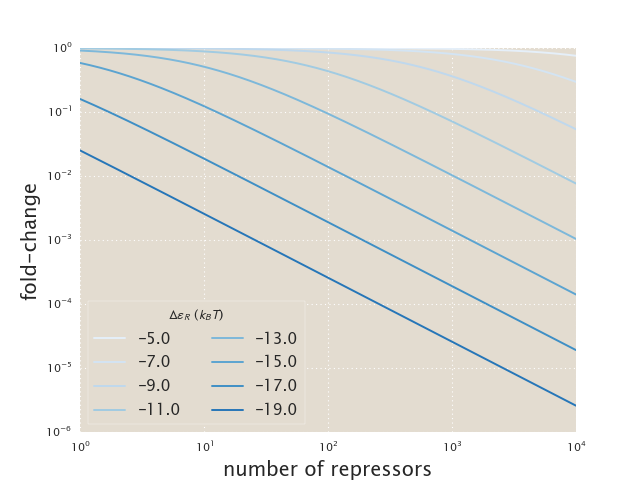

In [3]:
# Set up varying parameters.
num_repressors = np.logspace(0, 4, 500) 
binding_energies = np.arange(5, 20, 2)

# Evaluate and plot the fold-change predictions.
colors = sns.color_palette('Blues', n_colors=10)
plt.figure()
for i, ep in enumerate(binding_energies):
    fc = fold_change(num_repressors, -ep)
    plt.plot(num_repressors, fc, '-', color=colors[i], label='{0:.1f}'.format(-ep))
plt.xlabel('number of repressors', fontsize=18)
plt.ylabel('fold-change', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', title=r'$\Delta\varepsilon_{R}$ ($k_BT$)',
          fontsize=14, ncol=2)


This agrees well with our intuition. As the number of repressors in the cell increases, the more the target gene is repressed. However this is counteracted by the binding energy of the repressor to the specific operator. As this interaction becomes stronger, the more likely a repressor is to be bound to the DNA and decrease expression. Instead of just plotting a few target binding energies, we can generate a heatmap over a large array of energies to get an idea for the landscape.

<IPython.core.display.Javascript object>


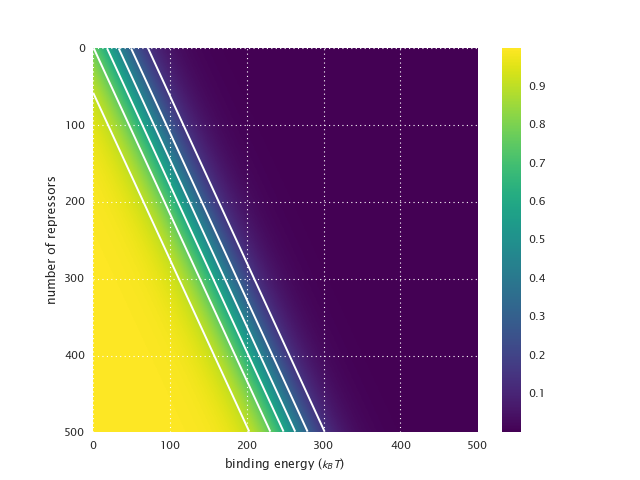

In [4]:
# Generate a hetmap of fold change.
num_repressors = np.logspace(0, 4, 500)
binding_energies= np.linspace(-5, -25, 500)
mesh_x, mesh_y = np.meshgrid(num_repressors, binding_energies)
x = np.ravel(mesh_x)
y = np.ravel(mesh_y)
fc = fold_change(x, y)

# Reshape the output to the meshgrid shape.
fc_rshp = fc.reshape(mesh_x.shape)

# Show the heatmap.
plt.figure()
plt.imshow(np.rot90(fc_rshp), cmap=plt.cm.viridis)
plt.colorbar()
plt.contour(np.rot90(fc_rshp), colors='w')
plt.ylabel('number of repressors')
plt.xlabel('binding energy ($k_BT$)')



##  Summary of the image set

##  Correcting for uneven illumination.

Since we are interested in extracting quantitative information from these images, it is important that the flurorescence value of each individual cell is directly comparable with the others. To do this, we must first ensure that the illumination across the image is even. In this particular set-up, each field of view is being illuminated with a collimated laser which should have a two-dimensional gaussian profile across the image. We can see that quite clearly by looking at the illumination of a uniformly fluorescent slide.

<IPython.core.display.Javascript object>


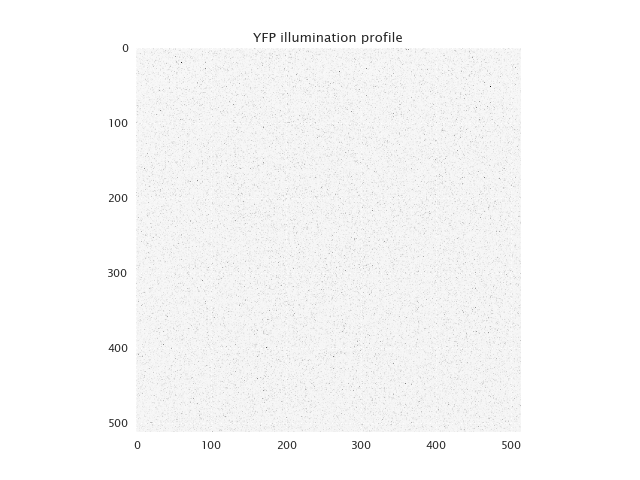

In [7]:
# Load and display a uniformly fluorescent slide.
illum_profile = skimage.io.imread('../data/20161119/20161118_illumination_profile_1/20161118_illumination_profile_1_MMStack_Pos0.ome.tif')
rfp_profile = illum_profile[0, :, :]
yfp_profile = illum_profile[1, :, :]
plt.figure()
plt.imshow(yfp_profile, cmap=plt.cm.viridis)
plt.title('YFP illumination profile')

## Generate uniform illumination images.

In [8]:
# #################
def average_stack(im, median_filt=True):
    """
    Computes an average image from a provided array of images.

    Parameters
    ----------
    im : list or arrays of 2d-arrays
        Stack of images to be filtered.
    median_filt : bool
        If True, each image will be median filtered before averaging.
        Median filtering is performed using a 3x3 square structural element.

    Returns
    -------
    im_avg : 2d-array
        averaged image with a type of int.
    """

    # Determine if the images should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = [scipy.ndimage.median_filter(i, footprint=selem) for i in im]
    else:
        im = im_filt

    # Generate and empty image to store the averaged image.
    im_avg = np.zeros_like(im[0]).astype(int)
    for i in im:
        im_avg += i
    im_avg = im_avg / len(im)
    return im_avg


def generate_flatfield(im, im_dark, im_field, median_filt=True):
    """
    Corrects illumination of a given image using a dark image and an image of
    the flat illumination.

    Parameters
    ----------
    im : 2d-array
        Image to be flattened.
    im_dark : 2d-array
        Average image of camera shot noise (no illumination).
    im_field: 2d-array
        Average image of fluorescence illumination.
    median_filt : bool
        If True, the image to be corrected will be median filtered with a
        3x3 square structural element.

    Returns
    -------
    im_flat : 2d-array
        Image corrected for uneven fluorescence illumination. This is performed
        as

        im_flat = ((im - im_dark) / (im_field - im_dark)) *
                   mean(im_field - im_dark)

    Raises
    ------
    RuntimeError
        Thrown if bright image and dark image are approximately equal. This
        will result in a division by zero.
    """

    # Ensure that the same image is not being provided as the bright and dark.
    if np.isclose(im_field, im_dark).all():
        raise RuntimeError('im_bright and im_dark are approximately equal.')

    # Compute the mean difference between the bright and dark image.
    mean_diff = np.mean(im_field - im_dark)

    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im

    # Compute and return the flattened image.
    im_flat = ((im_filt - im_dark) / (im_field - im_dark)) * mean_diff
    return im_flat

In [21]:
# Load the two illumination profiles and camera noise.
profile_glob = glob.glob('../data/20161119/*profile*/*.tif')
# fp_glob = glob.glob('../data/lacI_titration_microscopy/*YFP_profile*/*.tif')
# rfp_glob = glob.glob('../data/lacI_titration_microscopy/*TRITC_profile*/*.tif')
noise_glob = glob.glob('../data/20161119/*noise*/*.tif')
profile_ims = skimage.io.ImageCollection(profile_glob, conserve_memory=False)
# yfp_ims = skimage.io.ImageCollection(yfp_glob, conserve_memory=False)
# rfp_ims = skimage.io.ImageCollection(rfp_glob, conserve_memory=False)
noise_ims = skimage.io.ImageCollection(noise_glob, conserve_memory=False)
yfp_profile = [profile_ims[i][1] for i, _ in enumerate(profile_ims)]
rfp_profile = [profile_ims[i][0] for i, _ in enumerate(profile_ims)]
yfp_noise = [noise_ims[i][1] for i, _ in enumerate(noise_ims)]
rfp_noise = [noise_ims[i][0] for i, _ in enumerate(noise_ims)]

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


In [22]:
# Generate the average images.
yfp_avg = average_stack(yfp_profile)
rfp_avg = average_stack(rfp_profile)
yfp_noise_avg = average_stack(yfp_noise)
rfp_noise_avg = average_stack(rfp_noise)

Define the functions necessary for segmentation.

In [23]:
# #################
def find_zero_crossings(im, selem, thresh):
    """
    This  function computes the gradients in pixel values of an image after
    applying a sobel filter to a given image. This  function is later used in
    the Laplacian of Gaussian cell segmenter (log_segmentation) function. The
    arguments are as follows.

    Parameters
    ----------
    im : 2d-array
        Image to be filtered.
    selem : 2d-array, bool
        Structural element used to compute gradients.
    thresh :  float
        Threshold to define gradients.

    Returns
    -------
    zero_cross : 2d-array
        Image with identified zero-crossings.

    Notes
    -----
    This function as well as `log_segmentation` were written by Justin Bois.
    http://bebi103.caltech.edu/
    """

    # apply a maximum and minimum filter to the image.
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)

    # Compute the gradients using a sobel filter.
    im_filt = skimage.filters.sobel(im)

    # Find the zero crossings.
    zero_cross = (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0)))\
        & (im_filt >= thresh)

    return zero_cross


# #################
def log_segmentation(im, selem='default', thresh=0.0001, radius=2.0,
                     median_filt=True, clear_border=True, label=False):
    """
    This function computes the Laplacian of a gaussian filtered image and
    detects object edges as regions which cross zero in the derivative.

    Parameters
    ----------
    im :  2d-array
        Image to be processed. Must be a single channel image.
    selem : 2d-array, bool
        Structural element for identifying zero crossings. Default value is
        a 2x2 pixel square.
    radius : float
        Radius for gaussian filter prior to computation of derivatives.
    median_filt : bool
        If True, the input image will be median filtered with a 3x3 structural
        element prior to segmentation.
    selem : 2d-array, bool
        Structural element to be applied for laplacian calculation.
    thresh : float
        Threshold past which
    clear_border : bool
        If True, segmented objects touching the border will be removed.
        Default is True.
    label : bool
        If True, segmented objecs will be labeled. Default is False.

    Returns
    -------
    im_final : 2d-array
        Final segmentation mask. If label==True, the output will be a integer
        labeled image. If label==False, the output will be a bool.

    Notes
    -----
    We thank Justin Bois in his help writing this function.
    https://bebi103.caltech.edu
    """

    # Test that the provided image is only 2-d.
    if len(np.shape(im)) > 2:
        raise ValueError('image must be a single channel!')

    # Determine if the image should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im
    # Ensure that the provided image is a float.
    if np.max(im) > 1.0:
        im_float = skimage.img_as_float(im_filt)
    else:
        im_float = im_filt

    # Compute the LoG filter of the image.
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, radius)

    # Define the structural element.
    if selem == 'default':
        selem = skimage.morphology.square(3)

    # Using find_zero_crossings, identify the edges of objects.
    edges = find_zero_crossings(im_LoG, selem, thresh)

    # Skeletonize the edges to a line with a single pixel width.
    skel_im = skimage.morphology.skeletonize(edges)

    # Fill the holes to generate binary image.
    im_fill = scipy.ndimage.morphology.binary_fill_holes(skel_im)

    # Remove small objects and objects touching border.
    im_final = skimage.morphology.remove_small_objects(im_fill)
    if clear_border is True:
        im_final = skimage.segmentation.clear_border(im_final, buffer_size=5)

    # Determine if the objects should be labeled.
    if label is True:
        im_final = skimage.measure.label(im_final)

    # Return the labeled image.
    return im_final


# #################
def props_to_df(mask, physical_distance=1, intensity_image=None):
    """
    Converts the output of skimage.measure.regionprops to a nicely
    formatted pandas DataFrame.

    Parameters
    ----------
    mask : 2d-array, int
        Segmentation mask containing objects to be measured.
    physical_distance : int or float
        Interpixel distance of the image. This will be used to
        convert the area measurements to meaningful units.
    intensity_image : 2d-array
        Intensity image for intensity based measurements. If none is
        provided, only region based measurements will be returned.

    Returns
    -------
    df : pandas DataFrame
        Tidy DataFrame containing all measurements.

    """

    # Ensure that there is at least one object in the image.
    if np.max(mask) == 0:
        raise ValueError('no objects found in image.')

    # Define the values that are to be extracted.
    REGIONPROPS = ('area', 'eccentricity', 'solidity',
                   'mean_intensity')

    if intensity_image is None:
        measurements = REGIONPROPS[:-3]
    else:
        measurements = REGIONPROPS

    # Iterate through and extract the props.
    props = skimage.measure.regionprops(mask,
                                        intensity_image=intensity_image)
    for i, p in enumerate(props):
        extracted = []
        for val in measurements:
            extracted.append(p[val])

        if i == 0:
            df = pd.DataFrame(extracted).T
        else:
            df2 = pd.DataFrame(extracted).T
            df = df.append(df2)
    df.columns = measurements
    df['area'] = df['area'] * physical_distance**2
    return df

def generate_flatfield(im, im_dark, im_field, median_filt=True):
    """
    Corrects illumination of a given image using a dark image and an image of
    the flat illumination.

    Parameters
    ----------
    im : 2d-array
        Image to be flattened.
    im_dark : 2d-array
        Average image of camera shot noise (no illumination).
    im_field: 2d-array
        Average image of fluorescence illumination.
    median_filt : bool
        If True, the image to be corrected will be median filtered with a
        3x3 square structural element.

    Returns
    -------
    im_flat : 2d-array
        Image corrected for uneven fluorescence illumination. This is performed
        as

        im_flat = ((im - im_dark) / (im_field - im_dark)) *
                   mean(im_field - im_dark)

    Raises
    ------
    RuntimeError
        Thrown if bright image and dark image are approximately equal. This
        will result in a division by zero.
    """

    # Ensure that the same image is not being provided as the bright and dark.
    if np.isclose(im_field, im_dark).all():
        raise RuntimeError('im_bright and im_dark are approximately equal.')

    # Compute the mean difference between the bright and dark image.
    mean_diff = np.mean(im_field - im_dark)

    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im

    # Compute and return the flattened image.
    im_flat = ((im_filt - im_dark) / (im_field - im_dark)) * mean_diff
    return im_flat

# #################
def ome_split(im):
    """Splits an ome.tiff image into individual channels"""
    if len(np.shape(im)) != 3:
        raise RuntimeError('provided image must be a single image')
    ims = []
    for i in range(np.shape(im)[-1]):
        ims.append(im[:, :, i])
    return ims


In [28]:
# Start with O2.
data_dir = '../data/20161119/'
strains = ['auto', 'delta', 'wt', 'RBS1147', 'RBS446', 'RBS1027', 'RBS1', 'RBS1L']
copy_number = [0, 0, 22, 60, 124, 260, 1220, 1740]
operator = ['O1', 'O2', 'O3']
binding_energies = [-15.3, -13.9, -9.7]
dfs = []
for i, op in enumerate(operator):
    for j, rbs in enumerate(strains):
        # Glob the right strain.
        strain_glob = glob.glob(data_dir + '*' + str(op) + '*' + str(rbs) + '*/*.tif')
        strain_ims = skimage.io.ImageCollection(strain_glob, conserve_memory=False)
        
        # Iterate through each image.
        for k, im in enumerate(strain_ims):
            _, rfp, yfp = ome_split(im)
            
            # Generate the flatfield image.
#             rfp_flat = generate_flatfield(rfp, rfp_noise_avg, rfp_avg) 
            yfp_flat = generate_flatfield(yfp, rfp_noise_avg, rfp_avg) 
            
            # Segment the image.
            rfp_seg = log_segmentation(rfp, label=True)
            
            # Get the region props.
            _out = props_to_df(rfp_seg, physical_distance=0.160, intensity_image=yfp_flat)

            _out.insert(0, 'repressors', copy_number[j])
            _out.insert(0, 'strain', rbs)
            _out.insert(0, 'binding_energy', binding_energies[i])
            _out.insert(0, 'operator', op)
            _out.insert(0, 'date', 20161106)
            dfs.append(_out)
            
# Flatten the data frame.
cell_data = pd.concat(dfs, axis=0) 

/Users/gchure/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:103: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [33]:
# Apply thresholds.
cells = cell_data[(cell_data.solidity > 0.8) & (cell_data.area > 0.5) & (cell_data.area < 6)]

fold_changes = []
for i, op in enumerate(operator):
    # Get the operator.
    data = cells[cells.operator==op]
    grouped_data = pd.groupby(data, ['strain', 'repressors']).mean_intensity.mean()
    fc = (grouped_data - grouped_data['auto'].values) / (grouped_data['delta'].values - grouped_data['auto'].values)
    fc = pd.DataFrame(fc.reset_index(name='fold_change'))
    fc.insert(0, 'binding_energy', binding_energies[i])
    fc.insert(0, 'operator', op)
    fold_changes.append(fc)
flat = pd.concat(fold_changes)

In [34]:
fc_grouped = pd.groupby(flat, ['binding_energy'])

<IPython.core.display.Javascript object>


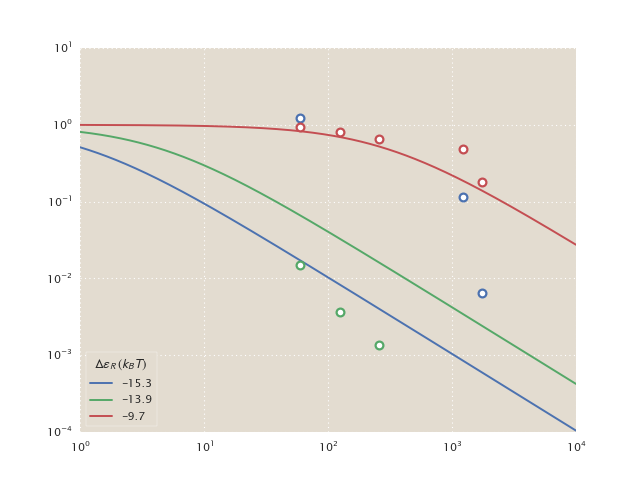

In [35]:
plt.figure()
# Plot the theoretical curves.
rep_range = np.logspace(0, 4, 500)
colors = sns.color_palette('deep', n_colors=8)
for i, ep in enumerate(binding_energies):
    theo_fc = fold_change(rep_range, ep)
    plt.plot(rep_range, theo_fc, label=ep, color=colors[i])
plt.legend(loc='lower left', title=r'$\Delta\varepsilon_R\,(k_BT)$')    

i = 0
for group, data in fc_grouped:
    plt.plot(data.repressors, data.fold_change, 'o', markeredgewidth=2,
             markerfacecolor='w', markeredgecolor=colors[i])
    i+=1 
plt.xscale('log')
plt.yscale('log')

In [406]:
flat

,operator,binding_energy,strain,repressors,fold_change
0,O1,-15.3,RBS1,1220,0.031040
1,O1,-15.3,RBS1027,260,-0.012589
2,O1,-15.3,RBS1147,60,0.077381
3,O1,-15.3,RBS446,124,-0.008579
4,O1,-15.3,auto,0,0.000000
5,O1,-15.3,delta,0,1.000000
6,O1,-15.3,wt,22,0.060455
0,O2,-13.9,RBS1,1220,0.006638
1,O2,-13.9,RBS1027,260,-0.020204
2,O2,-13.9,RBS1147,60,0.084861


In [317]:
z

,,mean_intensity
strain,repressors,
RBS1,1220,0.645879
RBS1027,260,0.854427
RBS1147,60,1.170381
RBS1L,1740,0.286711
RBS446,124,1.057943
auto,0,0.000000
delta,0,1.000000
wt,22,1.214873
